In [1]:
!pip3 install torch torchvision torchaudio

In [2]:
import numpy as np
import time
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from logging import raiseExceptions

#1.  Forward Propagation Process:


In [3]:
def initialize_parameters(layer_dims):
    """
    Initializes weight matrices and bias vectors for each layer in the neural network.

    input: an array of the dimensions of each layer in the network (layer 0 is the size of the flattened input, layer L is the output softmax)

    output: a dictionary containing the initialized W and b parameters of each layer (W1…WL, b1…bL).
            Where  Wl is a weight matrix of shape (layer_dims[l], layer_dims previous layer)
            bl is a bias vector of shape (layer_dims[l], 1)

    """
    initialized_parameters_dic = {}
    for layer in range(1, len(layer_dims)):
        initialized_parameters_dic[f'W{layer}'] = torch.randn(layer_dims[layer], layer_dims[layer-1]) * torch.sqrt(torch.tensor(2.0) / layer_dims[layer-1])
        initialized_parameters_dic[f'b{layer}'] = torch.zeros(layer_dims[layer], 1)
    return initialized_parameters_dic

In [4]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    input:
    A – the activations of the previous layer (of shape [size of previous layer, 1])
    W – the weight matrix of the current layer (of shape [size of current layer, size of previous layer])
    B – the bias vector of the current layer (of shape [size of current layer, 1])

    Output:
    Z – the linear component of the activation function (i.e., the value before applying the non-linear function)
    linear_cache – a dictionary containing A, W, b (stored for making the backpropagation easier to compute)

    """

    # Convert tensors to the same data type (float)
    A = A.type(torch.float32)
    W = W.type(torch.float32)

    Z = torch.mm(W, A) + b
    linear_cache = {'A': A, 'W': W, 'b': b}
    return Z, linear_cache


In [5]:
def softmax(Z):
    """
    Implements the softmax function.

    Input:
    Z – the linear component of the activation function

    Output:
    A – the activations of the layer
    activation_cache – returns Z, which will be useful for the backpropagation

    """
    activation_cache = Z
    Z = Z - Z.max(dim=0, keepdim=True).values
    y = torch.exp(Z)
    A = y / y.sum(dim=0, keepdim=True)
    return A, activation_cache

In [6]:
def relu(Z):
    """
    Implements the ReLU function.

    Input:
    Z – the linear component of the activation function

    Output:
    A – the activations of the layer
    activation_cache – returns Z, which will be useful for the backpropagation

    """
    activation_cache = Z
    A = torch.maximum(Z, torch.tensor(0.0))
    return A, activation_cache

In [7]:
def linear_activation_forward(A_prev, W, B, activation):
    """
    Implements the forward propagation for the LINEAR->ACTIVATION layer

    Input:
    A_prev – activations of the previous layer
    W – the weights matrix of the current layer
    B – the bias vector of the current layer
    Activation – the activation function to be used (a string, either “softmax” or “relu”)

    Output:
    A – the activations of the current layer
    cache – a joint dictionary containing both linear_cache and activation_cache

    """
    Z, linear_cache = linear_forward(A_prev, W, B)

    if activation == "softmax":
        A, activation_cache = softmax(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
    else:
      raise ValueError("Activation function isn't supported")

    cache = {'linear_cache': linear_cache, 'activation_cache': activation_cache}
    return A, cache

In [8]:
def L_model_forward(X, parameters, use_batchnorm = False):
    """
    Implements forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SOFTMAX computation

    Input:
    X – the data, numpy array of shape (input size, number of examples)
    parameters – the initialized W and b parameters of each layer
    use_batchnorm - a boolean flag used to determine whether to apply batchnorm after the activation

    Output:
    AL – the last post-activation value
    caches – a list of all the cache objects generated by the linear_forward function
    """

    caches = []
    A = X
    layers = len(parameters) // 2  # the parameters dic contains both the W and b for each layer

    for l in range(1,layers):
        prev_layer = A
        W = parameters[f'W{l}']
        B = parameters[f'b{l}']
        A, cache = linear_activation_forward(prev_layer, W, B, "relu")
        if use_batchnorm:
          A = apply_batchnorm(A)
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters[f'W{layers}'], parameters[f'b{layers}'], "softmax") # the last layer uses softmax
    caches.append(cache)

    return AL, caches

In [9]:
def compute_cost(AL, Y, parameters = {}, lambd = 0):
    """
    Implements the categorical cross-entropy cost function.

    Arguments:
    AL -- probability vector corresponding to label predictions, shape (num_of_classes, number of examples)
    Y -- the labels vector (i.e., the ground truth), shape (num_of_classes, number of examples)
    parameters -- the W and b parameters of each layer (dic)
    lambd -- regularization hyperparameter, scalar

    Returns:
    cost -- the cross-entropy cost with L2 regularization
    """

    m = Y.shape[1]
    cost = -(1/m) * torch.sum(Y * torch.log(AL + 1e-5))
    L2_regularization_cost = 0

    if lambd: # only if we use the L2 norm
      layers = len(parameters) // 2  # the parameters DNN dic contains both the W and b for each layer
      for l in range(layers):
        L2_regularization_cost += torch.sum(torch.pow(parameters["W" + str(l+1)], 2))
      L2_regularization_cost = (lambd / (2 * m)) * L2_regularization_cost

    cost += L2_regularization_cost
    cost = cost.item()

    return cost

In [10]:
def apply_batchnorm(A):
    """
    performs batchnorm on the received activation values of a given layer.

    Input:
    A - the activation values of a given layer

    output:
    NA - the normalized activation values, based on the formula learned in class
    """

    mean = A.mean(dim=1, keepdim=True)
    var = A.var(dim=1, keepdim=True) # unbiased=False
    NA = (A - mean) / torch.sqrt(var + 1e-5)  # adding small value to avoid division by zero

    return NA

#2.  Backward Propagation Process:

In [11]:
def Linear_backward(dZ, cache):
    """
    implements the linear part of the backward propagation process for a single layer

    Input:
    dZ – the gradient of the cost with respect to the linear output of the current layer (layer l)
    cache – tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Output:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """

    A_prev, W, b = cache.values()
    m = A_prev.shape[1]

    A_prev = A_prev.type(torch.float64)
    W = W.type(torch.float64)
    dZ = dZ.type(torch.float64)

    dA_prev = torch.mm(W.t(), dZ)
    dW = torch.mm(dZ, A_prev.t()) / m
    db = torch.sum(dZ, dim=1, keepdim=True) / m

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db

In [12]:
def relu_backward(dA, activation_cache):
    """
    Implements backward propagation for a ReLU unit

    Input:
    dA – the post-activation gradient
    activation_cache – contains Z (stored during the forward propagation)

    Output:
    dZ – gradient of the cost with respect to Z
    """
    Z = activation_cache
    dZ = dA.clone()
    dZ[Z <= 0] = 0
    return dZ

In [13]:
def softmax_backward(dA, activation_cache):
    """
    Implements backward propagation for a softmax unit

    Input:
    dA – the post-activation gradient
    activation_cache – contains Z (stored during the forward propagation)

    Output:
    dZ – gradient of the cost with respect to Z
    """
    Y = activation_cache
    dZ = dA - Y
    return dZ

In [14]:
def linear_activation_backward(dA, cache, activation):
    """
    Implements the backward propagation for the LINEAR->ACTIVATION layer.

    Input:
    dA – post activation gradient of the current layer
    cache – contains both the linear cache and the activations cache

    Output:
    dA_prev – Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW – Gradient of the cost with respect to W (current layer l), same shape as W
    db – Gradient of the cost with respect to b (current layer l), same shape as b

    """
    if activation == "relu":
        linear_cache, activation_cache = cache.values()
        dZ = relu_backward(dA, activation_cache)
    elif activation == "softmax":
        linear_cache, activation_cache, Y = cache.values()
        dZ = softmax_backward(dA, Y)
    else:
        raise Exception("Activation function not supported")

    dA_prev, dW, db = Linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

In [15]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the entire network.

    Input:
    AL - the probabilities vector, the output of the forward propagation (L_model_forward)
    Y - the true labels vector (the "ground truth" - true classifications)
    Caches - list of caches containing for each layer: a) the linear cache; b) the activation cache

    Output:
    Grads - a dictionary with the gradients
                grads["dA" + str(l)] = ...
                grads["dW" + str(l)] = ...
                grads["db" + str(l)] = ...

    """
    grads = {}
    layers = len(caches)
    m = AL.shape[1]

    # softmax backward
    curr_cache = caches[layers-1]
    curr_cache['Y'] = Y
    grads["dA" + str(layers-1)], grads["dW" + str(layers)], grads["db" + str(layers)] = linear_activation_backward(AL, curr_cache, "softmax")
    dA_prev = grads["dA" + str(layers-1)]

    # layers backword
    for layer in reversed(range(layers-1)):
        curr_cache = caches[layer]
        dA_prev_curr, dW_curr, db_curr = linear_activation_backward(dA_prev, curr_cache, "relu")
        grads["dA" + str(layer)] = dA_prev_curr
        grads["dW" + str(layer + 1)] = dW_curr
        grads["db" + str(layer + 1)] = db_curr
        dA_prev = dA_prev_curr

    return grads

In [16]:
def Update_parameters(parameters, grads, learning_rate, lambd = 0):
    """
    Updates parameters using gradient descent

    Input:
    parameters – a python dictionary containing the DNN architecture’s parameters
    grads – a python dictionary containing the gradients (generated by L_model_backward)
    learning_rate – the learning rate used to update the parameters (the “alpha”)

    Output:
    parameters – the updated values of the parameters object provided as input
    """

    layers = len(parameters) // 2  # the parameters DNN dic contains both the W and b for each layer

    # Update rule for each parameter
    for l in range(layers):
      l2_norm = 0
      if lambd:
        l2_norm = (lambd / parameters["W" + str(l+1)].shape[1]) * parameters["W" + str(l+1)]
      parameters["W" + str(l+1)] -= learning_rate * (grads["dW" + str(l+1)]+ l2_norm)
      parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]

    return parameters

#3. Train The Network:

In [17]:
def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, batch_size, batch_norm = False, early_stop = False, seed = 25, lambd= 0):
    """
   Implements a L-layer neural network. All layers but the last  have the ReLU activation function,  the final layer  apply the softmax activation function.
   Works in the following order: initialize -> L_model_forward -> compute_cost -> L_model_backward -> update parameters

    Input:
    X – the input data, a numpy array of shape (height*width , number_of_examples)
    Y – the “real” labels of the data, a vector of shape (num_of_classes, number of examples)
    Layer_dims – a list containing the dimensions of each layer, including the input
    batch_size – the number of examples in a single training batch.
    batch_norm - a boolean flag used to determine whether to apply batchnorm after the activation in the forward propagation
    early_stop - a boolean flag used to determine whether to use an early stop using the validation
    seed - random seed


    Output:
    parameters – the parameters learnt by the system during the training (the same parameters that were updated in the update_parameters function).
    costs – the values of the cost function (calculated by the compute_cost function). One value is to be saved after each 100 training iterations (e.g. 3000 iterations -> 30 values).
    """
    np.random.seed(seed)

    if early_stop:
      X , X_val = X
      Y, Y_val = Y

    costs = []
    acc_validation = []
    num_iter = 0
    num_epoch = 0
    number_of_examples = X.shape[1]
    batch_num = int(number_of_examples / batch_size)
    parameters = initialize_parameters(layers_dims)

    for epoch in range(num_iterations):
      indices = np.random.permutation(number_of_examples)
      shuffled_X = X[:, indices]
      shuffled_Y = Y[:, indices]

      for batch in range(batch_num):

        start_idx, end_idx =  batch * batch_size, min((batch + 1) * batch_size, number_of_examples)
        curr_X = shuffled_X[:, start_idx:end_idx]
        curr_Y = shuffled_Y[:, start_idx:end_idx]

        AL, caches = L_model_forward(curr_X, parameters, batch_norm)  # forward propagation
        cost = compute_cost(AL, curr_Y, parameters, lambd)  # compute cost
        grads = L_model_backward(AL, curr_Y, caches)  # backward propagation
        parameters = Update_parameters(parameters, grads, learning_rate, lambd)  # update parameters

        if early_stop:
          curr_acc = Predict(X=X_val, Y=Y_val, parameters=parameters, use_batchnorm = batch_norm)
          acc_validation.append(curr_acc)
          if (20 < num_epoch) and (0 <= (acc_validation[-2] - acc_validation[-1]) < 1e-10):  # at list 20 epochs and then stop if there is no improvements on the validation set
            costs.append(cost)
            return parameters, costs, acc_validation, num_iter, num_epoch


        if num_iter % 100 == 0:
          costs.append(cost)
        num_iter += 1

      num_epoch +=1

    if early_stop:
        return parameters, costs, acc_validation, num_iter, num_epoch
    else:
        return parameters, costs

In [18]:
def Predict(X, Y, parameters, use_batchnorm = False):
    """
    The function receives an input data and the true labels and calculates the accuracy of the trained neural network on the data.

    Input:
    X – the input data, a numpy array of shape (height*width, number_of_examples)
    Y – the “real” labels of the data, a vector of shape (num_of_classes, number of examples)
    Parameters – a python dictionary containing the DNN architecture’s parameters

    Output:
    accuracy – the accuracy measure of the neural net on the provided data (i.e. the percentage of the samples for which the correct label receives the hughest confidence score). Use the softmax function to normalize the output values.

    """
    predictions , cache  = L_model_forward(X, parameters, use_batchnorm)

    predictions_class = torch.argmax(predictions, dim=0)
    labels = torch.argmax(Y, dim=0)
    accuracy = torch.mean((predictions_class == labels).float())
    return accuracy.item()

#4. MNIST dataset Classification

In [19]:
def Dataset_Loader(validation_set_size, seed=25):
    """
    Loads and preprocesses the MNIST dataset using KERAS

    Args:
    validation_set_size (float): The size of the validation set as a fraction of the training set.
    seed (int): The random seed for data splitting.

    Returns:
    Tuple of torch tensors: (X_train, X_val, X_test, Y_train, Y_val, Y_test)
        - X_train (torch.Tensor): Training data features (input), shape (784, m_train).
        - X_val (torch.Tensor): Validation data features (input), shape (784, m_val).
        - X_test (torch.Tensor): Testing data features (input), shape (784, m_test).
        - Y_train (torch.Tensor): Training data labels (output), shape (10, m_train).
        - Y_val (torch.Tensor): Validation data labels (output), shape (10, m_val).
        - Y_test (torch.Tensor): Testing data labels (output), shape (10, m_test).

    """
    from keras.datasets import mnist
    (train_X, train_y), (test_X, test_y) = mnist.load_data()

    # preprocess
    train_X = train_X.reshape(train_X.shape[0], -1)/255
    X_test = test_X.reshape(test_X.shape[0], -1)/255
    train_y = np.eye(10)[train_y]
    Y_test = np.eye(10)[test_y]

    X_train, X_val, Y_train, Y_val = train_test_split(train_X, train_y, test_size=validation_set_size, random_state=seed)

    return torch.tensor(X_train.T), torch.tensor(X_val.T), torch.tensor(X_test.T), torch.tensor(Y_train.T), torch.tensor(Y_val.T), torch.tensor(Y_test.T)

In [20]:
def print_results(costs, acc_validation, num_iter, num_epoch , acc_train, acc_test):
    """
    Print the final results and statistics of a trained neural network.

    Args:
    costs (list): List of cost values during training.
    acc_validation (list): List of validation accuracy values during training.
    num_iter (int): Total number of iterations (batches) during training.
    num_epoch (int): Total number of epochs during training.
    acc_train (float): Training accuracy achieved by the model.
    acc_test (float): Testing accuracy achieved by the model.

    Prints:
    - Final cost.
    - Number of iterations.
    - Number of epochs.
    - Training accuracy.
    - Validation accuracy.
    - Testing accuracy.
    """
    print(f"Final Cost: {round(costs[-1], 3)}")
    print(f"Number of Iterations: {num_iter}")
    print(f"Number of Epochs: {num_epoch}")
    print(f"Train Accuracy: {round(acc_train, 3)}")
    print(f"Validation Accuracy: {round(acc_validation[-1], 3)}")
    print(f"Test Accuracy: {round(acc_test, 3)}")
    print(f"All Costs: {costs}")

In [21]:
def plot_graphs(costs, acc_validation):
    """
    Plot the cost and validation accuracy over iterations.

    Args:
    costs (list): List of cost values during training.
    acc_validation (list): List of validation accuracy values during training.

    Displays two subplots:
    1. Cost over iterations.
    2. Validation accuracy over iterations.
    """
    plt.figure(figsize=(12, 5))

    # Plotting cost
    plt.subplot(1, 2, 1)
    plt.plot(costs, color = '#609d9e')
    plt.title('Cost over iterations')
    plt.xlabel('Iterations / 100')
    plt.ylabel('Cost')

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(acc_validation, color = '#609d9e')
    plt.title('Validation Accuracy over iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')

    plt.show()

In [22]:
def run_experiments_and_print_results():
    """
    Runs the full experiments plan and prints the results
    """

    # Network configuration
    layers_dims = [28*28, 20, 7, 5, 10]
    learning_rate = 0.009
    batch_size = 64
    num_iterations = 100
    early_stop = True
    lambd = 0.3
    seed = 2304

    # Load the DB
    X_train, X_val, X_test, Y_train, Y_val, Y_test = Dataset_Loader(validation_set_size=0.2, seed=seed)

    print('Classification on the MNIST dataset')

    # without batch norm
    print('Without batch normalization:')
    start_time = time.time()
    parameters, costs, acc_validation, num_iter, num_epoch = L_layer_model(X=[X_train, X_val], Y=[Y_train, Y_val], layers_dims=layers_dims, learning_rate=learning_rate, num_iterations=num_iterations, batch_size=batch_size, batch_norm=False, early_stop=early_stop, seed=seed)
    end_time = time.time()
    acc_train = Predict(X_train, Y_train, parameters)
    acc_test = Predict(X_test, Y_test, parameters)
    print_results(costs, acc_validation, num_iter, num_epoch, acc_train, acc_test)
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    plot_graphs(costs, acc_validation)

    # with batch norm
    print('\nWith batch normalization:')
    start_time = time.time()
    parameters_bn, costs, acc_validation, num_iter, num_epoch = L_layer_model(X=[X_train, X_val], Y=[Y_train, Y_val], layers_dims=layers_dims, learning_rate=learning_rate, num_iterations=num_iterations, batch_size=batch_size, batch_norm=True, early_stop=early_stop, seed=seed)
    end_time = time.time()
    acc_train = Predict(X=X_train, Y=Y_train, parameters=parameters_bn, use_batchnorm=True)
    acc_test = Predict(X=X_test, Y=Y_test, parameters=parameters_bn, use_batchnorm=True)
    print_results(costs, acc_validation, num_iter, num_epoch, acc_train, acc_test)
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    plot_graphs(costs, acc_validation)

    # without batch norm and with L2 NORM
    print('\nWith L2 norm regularization (without batch normalization):')
    start_time = time.time()
    parameters_l2, costs, acc_validation, num_iter, num_epoch = L_layer_model(X=[X_train, X_val], Y=[Y_train, Y_val], layers_dims=layers_dims, learning_rate=learning_rate, num_iterations=num_iterations, batch_size=batch_size, batch_norm=False, early_stop=early_stop, seed=seed, lambd=lambd)
    end_time = time.time()
    acc_train = Predict(X_train, Y_train, parameters_l2)
    acc_test = Predict(X_test, Y_test, parameters_l2)
    print_results(costs, acc_validation, num_iter, num_epoch, acc_train, acc_test)
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    plot_graphs(costs, acc_validation)

    print('Weights values compare with and without L2:')
    for w in range(1, len(parameters)//2 + 1):
      print(f'W{w} without L2')
      print(parameters[f'W{w}'])
      print(f'W{w} with L2')
      print(parameters_l2[f'W{w}'])

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Classification on the MNIST dataset
Without batch normalization:
Final Cost: 0.17
Number of Iterations: 15785
Number of Epochs: 21
Train Accuracy: 0.933
Validation Accuracy: 0.921
Test Accuracy: 0.921
All Costs: [2.303698267787695, 2.238008050248027, 2.175753911025822, 2.102426859550178, 1.9587602447718382, 1.8664723122492433, 1.836562369018793, 1.6794943399727345, 1.5129466489888728, 1.515131589025259, 1.4809197685681283, 1.2647934589767829, 1.3692264672135934, 1.2224438465200365, 1.1283973573008552, 1.2522878898889758, 0.9679408105730545, 1.1944909898447804, 0.9496855295437854, 0.8257944599899929, 1.112078891164856, 1.0346213152224664, 0.9040202043543104, 0.8499242578982376, 0.8682343181499164, 0.7829262108571129, 0.9686106522713089, 0.6648689054127317, 0.7509569067042321, 0.6042992774746381, 0.927693433535751, 0.6043459825377795, 0.6323280638753204, 0.7936497233604314, 1.00717823515879, 0.5246290573049919, 0.5654027244199824, 0.7066

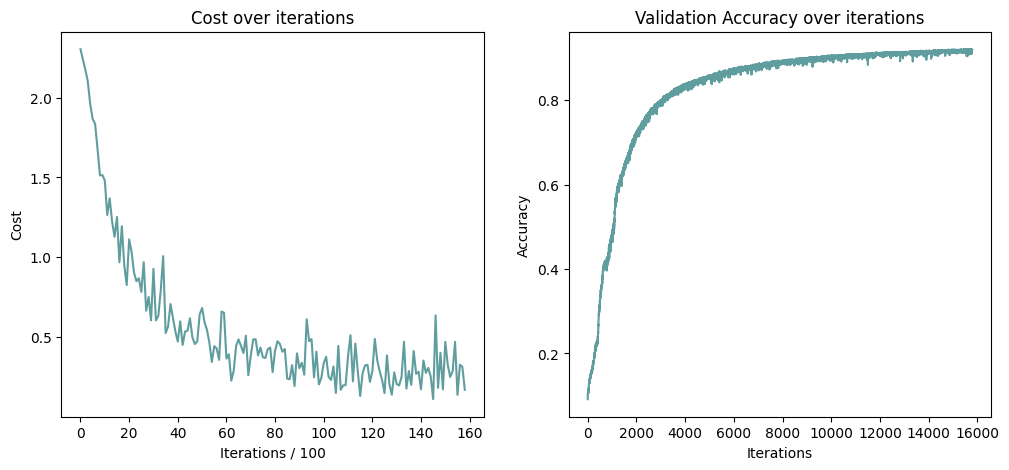


With batch normalization:
Final Cost: 0.388
Number of Iterations: 15771
Number of Epochs: 21
Train Accuracy: 0.908
Validation Accuracy: 0.901
Test Accuracy: 0.901
All Costs: [3.0831531761214137, 2.327526491135359, 2.0461767963133752, 1.747170310933143, 1.9021721796598285, 1.5745014859130606, 1.630604131380096, 1.5152309188997606, 1.4283404087182134, 1.5298106889240444, 1.4220775366120506, 1.320931294001639, 1.3304264770122245, 1.3444151380681433, 1.2375000691390596, 1.2159121138392948, 1.192664364585653, 1.208718548878096, 0.9602860786253586, 1.0531615182117093, 1.041105289827101, 1.0232869668398052, 1.081837405290571, 1.1139459584956057, 1.0268187406472862, 0.9839950376481283, 0.9776204048539512, 1.0734249701199587, 1.0428884543362074, 0.928859731182456, 1.0827609163243324, 0.8423898846085649, 1.0194753298710566, 1.0577873526490293, 1.1028090499457903, 0.8280624041508418, 0.952272440190427, 0.8081576657714322, 0.8307110259775072, 0.737140421566437, 0.9498565806497936, 0.9079663865268

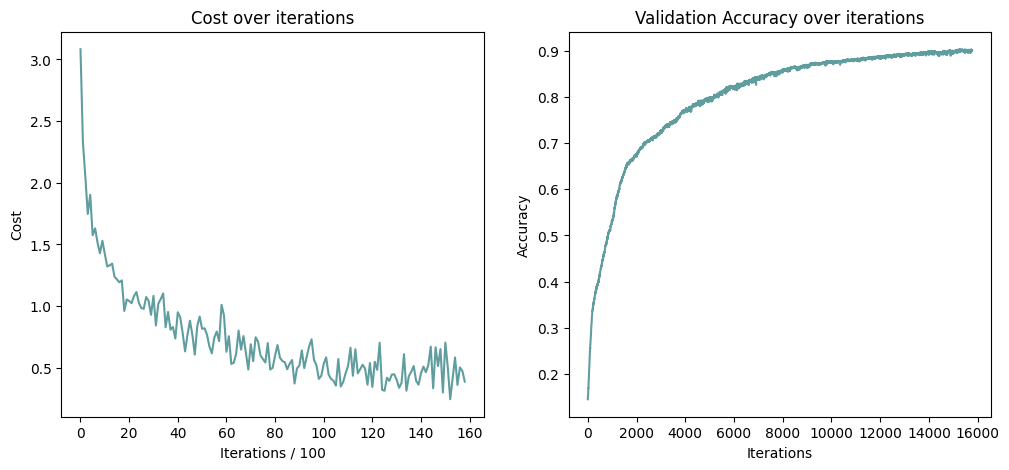


With L2 norm regularization (without batch normalization):
Final Cost: 1.131
Number of Iterations: 15805
Number of Epochs: 21
Train Accuracy: 0.739
Validation Accuracy: 0.73
Test Accuracy: 0.746
All Costs: [2.502286709845066, 2.410273026674986, 2.319187667220831, 2.2087541837245226, 2.2464052252471447, 2.2200952041894197, 2.1416654675267637, 1.980865755584091, 1.9009451465681195, 1.9021367682144046, 1.9990215739235282, 1.8919340977445245, 1.8417862569913268, 1.875980949960649, 1.7978325756266713, 1.8509749975055456, 1.7609367775730789, 1.7035563420504332, 1.6893186746165156, 1.619818442966789, 1.635510953143239, 1.6901987716555595, 1.5401291670277715, 1.6090850550681353, 1.560030547901988, 1.5898238886147738, 1.6031099748797715, 1.5198619719594717, 1.517435380257666, 1.479879230260849, 1.5771162072196603, 1.3631946668028831, 1.519415095448494, 1.6879157717339694, 1.4668820933438838, 1.4067755257710814, 1.4946719254367054, 1.4227864758577198, 1.4383708701934665, 1.305639800382778, 1.47

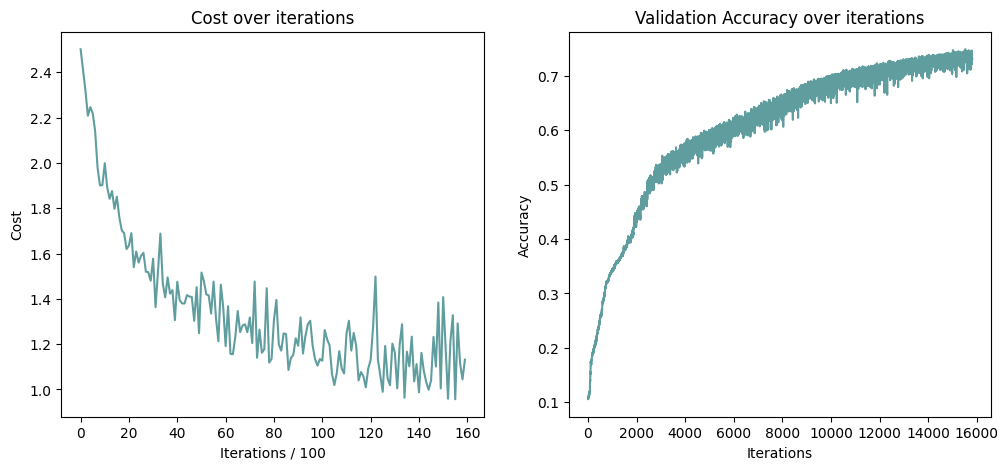

Weights values compare with and without L2:
W1 without L2
tensor([[-0.0102,  0.0843, -0.0234,  ..., -0.0610, -0.0608, -0.0076],
        [ 0.0940, -0.0074, -0.0660,  ..., -0.0095,  0.0736, -0.0696],
        [ 0.0195,  0.0407, -0.0092,  ..., -0.0355, -0.0660, -0.0051],
        ...,
        [-0.0625,  0.0021,  0.0137,  ...,  0.0308,  0.0416, -0.0090],
        [ 0.0113,  0.0259, -0.0396,  ..., -0.0385, -0.1035, -0.0666],
        [-0.0398,  0.0846, -0.0506,  ..., -0.0274, -0.0112,  0.0175]])
W1 with L2
tensor([[-0.0728,  0.0237,  0.0771,  ...,  0.0219,  0.0053, -0.0192],
        [ 0.0209, -0.0482, -0.0532,  ..., -0.0395,  0.0505,  0.0044],
        [ 0.0218,  0.0683,  0.0182,  ...,  0.0023, -0.0039,  0.0543],
        ...,
        [ 0.0575,  0.0421, -0.0567,  ...,  0.0477, -0.0213, -0.0231],
        [-0.0116,  0.0244, -0.0665,  ...,  0.0042,  0.0729,  0.0258],
        [ 0.0069,  0.0040,  0.0346,  ...,  0.0678, -0.0096, -0.0070]])
W2 without L2
tensor([[-6.1522e-01,  2.9665e-01,  4.4039e-01, -

In [23]:
if __name__ == '__main__':
  run_experiments_and_print_results()